In [2]:
import pandas as pd
import numpy as np

In [3]:
data=pd.read_csv('ratings.csv')

In [4]:
data

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
94,4,184,4
95,4,495,4
96,4,350,3
97,4,492,4


In [8]:
from scipy.sparse import csr_matrix
ratings=csr_matrix(
    (
        data['rating'].values,(data['user_id'].values,data['book_id'].values),
    )).toarray()
    # ,
    # shape=(len(data.user_id), len(data.item_id))).toarray()

In [99]:
# all(ratings.toarray()[0])

In [11]:
len(ratings.nonzero()[0])

99

In [12]:
total_user_item_interaction = np.count_nonzero(ratings)

In [13]:
total_user_item_interaction

99

In [18]:
import time
import numpy as np
from matplotlib import pyplot as plt

class MatrixDecomp:
    def __init__(self, ratings, n_factors, reg, learning_rate, iterations):
        self.ratings = ratings
        self.num_users = ratings.shape[0]
        self.num_items = ratings.shape[1]
        self.total_user_item_interaction = np.count_nonzero(ratings)  # Fixed variable name
        self.nonzero_interac_list = list(range(self.total_user_item_interaction))
        self.non_zero_row, self.non_zero_col = ratings.nonzero()
        self.latent_features = n_factors
        self.reg = reg
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.mse_epoch = []
        self.stop = False
        
    def initialize(self):
        self.now = time.time()
        # Initialize with smaller random values
        self.user_bias = np.random.normal(0, 0.1, size=self.num_users)
        self.item_bias = np.random.normal(0, 0.1, size=self.num_items)
        self.user_decomposed_matrix = np.random.normal(0, 0.1/np.sqrt(self.latent_features), 
                                                      size=(self.num_users, self.latent_features))
        self.item_decomposed_matrix = np.random.normal(0, 0.1/np.sqrt(self.latent_features), 
                                                      size=(self.num_items, self.latent_features))

    def update_parameters(self, error, user, item):
        # print("Updating Params")
        # Add clipping to prevent extreme values
        clip_value = 5.0
        
        # Update biases with clipping
        user_bias_grad = error - (self.reg * self.user_bias[user])
        item_bias_grad = error - (self.reg * self.item_bias[item])
        
        self.user_bias[user] += self.learning_rate * np.clip(user_bias_grad, -clip_value, clip_value)
        self.item_bias[item] += self.learning_rate * np.clip(item_bias_grad, -clip_value, clip_value)
        
        # Update matrices with clipping
        user_matrix_grad = error * self.item_decomposed_matrix[item] - self.reg * self.user_decomposed_matrix[user]
        item_matrix_grad = error * self.user_decomposed_matrix[user] - self.reg * self.item_decomposed_matrix[item]
        
        self.user_decomposed_matrix[user] += self.learning_rate * np.clip(user_matrix_grad, -clip_value, clip_value)
        self.item_decomposed_matrix[item] += self.learning_rate * np.clip(item_matrix_grad, -clip_value, clip_value)

    def predict(self, user, item):
        # print("prediciting")
        prediction = (self.user_bias[user] + 
                     self.item_bias[item] + 
                     np.dot(self.user_decomposed_matrix[user], self.item_decomposed_matrix[item]))
        # Clip predictions to prevent extreme values
        return np.clip(prediction, self.ratings.min(), self.ratings.max())

    def evaluate(self, epoch):
        # print("Evaluating")
        total_error = 0.0
        for i in self.nonzero_interac_list[:10]:
            user = self.non_zero_row[i]
            item = self.non_zero_col[i]
            prediction = self.predict(user, item)
            sq_error = (prediction - self.ratings[user, item]) ** 2
            total_error += sq_error
            
        if self.total_user_item_interaction > 0:  # Ensure we don't divide by zero
            mse = total_error / self.total_user_item_interaction
            self.mse_epoch.append(float(mse))  # Ensure we're storing a float
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"ave mse {np.round(self.mse_epoch[-1], 3)} ===> Total training time: {temp} seconds.")
        else:
            print("Error: No non-zero interactions found in the ratings matrix")

    def train(self):
        self.initialize()
        for epoch in range(1, self.iterations):
            # print(f"Epoch {epoch} running")
            np.random.shuffle(self.nonzero_interac_list)
            if not self.stop:
                for index in self.nonzero_interac_list[:10]:
                    print(index)
                    user, item = self.non_zero_row[index], self.non_zero_col[index]
                    pred_rat = self.predict(user, item)
                    error = self.ratings[user, item] - pred_rat
                    self.update_parameters(error, user, item)
                self.evaluate(epoch)
        self.plot_the_score()
    
    def plot_the_score(self):
        plt.figure(figsize=(18, 6))
        plt.plot(range(1, 1 + len(self.mse_epoch)), self.mse_epoch, marker='o')
        plt.title("SGD Custom Prepared USER & ITEM vector's Tr MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('Mean Square Error', fontsize=18)
        plt.xticks(range(1, len(self.mse_epoch) + 2), fontsize=15, rotation=90)
        plt.yticks(fontsize=15)
        plt.grid()
        plt.show()

In [19]:
recom=MatrixDecomp(ratings=ratings,n_factors=10,learning_rate=0.01,reg=0.02,iterations=30)

60
35
96
64
24
76
68
62
74
47
---> Epoch 1
ave mse 1.486 ===> Total training time: 0.011 seconds.
81
55
64
34
52
36
51
65
20
79
---> Epoch 2
ave mse 1.4 ===> Total training time: 0.014 seconds.
74
66
1
30
72
67
91
86
25
0
---> Epoch 3
ave mse 1.278 ===> Total training time: 0.016 seconds.
14
48
56
58
67
84
54
97
31
34
---> Epoch 4
ave mse 1.126 ===> Total training time: 0.019 seconds.
16
84
40
3
78
60
42
55
52
80
---> Epoch 5
ave mse 1.252 ===> Total training time: 0.022 seconds.
7
32
65
28
98
2
58
44
63
17
---> Epoch 6
ave mse 1.179 ===> Total training time: 0.024 seconds.
22
37
50
82
19
8
9
73
59
41
---> Epoch 7
ave mse 0.967 ===> Total training time: 0.027 seconds.
3
0
92
29
1
82
91
15
28
58
---> Epoch 8
ave mse 1.169 ===> Total training time: 0.029 seconds.
9
82
78
71
98
49
15
68
11
14
---> Epoch 9
ave mse 1.266 ===> Total training time: 0.032 seconds.
70
88
29
6
34
31
64
4
3
52
---> Epoch 10
ave mse 0.769 ===> Total training time: 0.035 seconds.
9
15
32
46
12
18
34
53
25
97
---> E

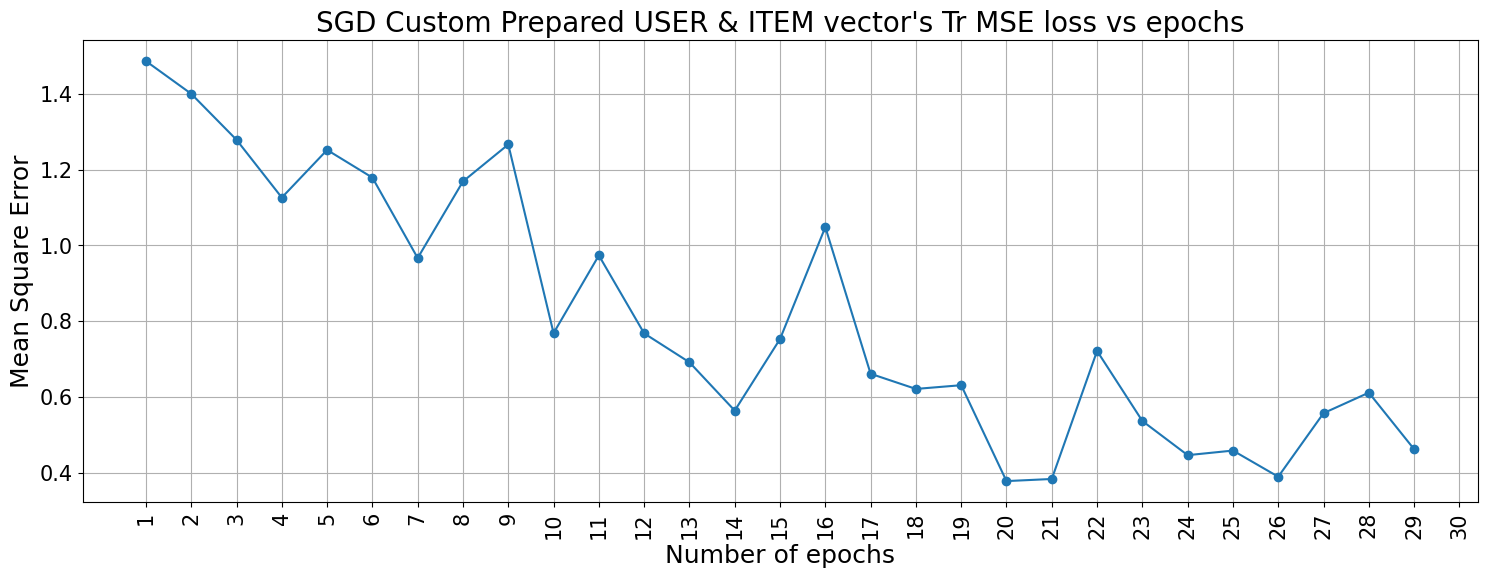

In [20]:
recom.train()

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load MovieLens data
def load_movielens_subset():
    # Load ratings data
    ratings = pd.read_csv('ml-latest-small/ratings.csv')
    
    # Take a subset of users and movies to make it manageable
    n_users = 1000  # Adjust this number based on your computational resources
    n_movies = 1000  # Adjust this number based on your computational resources
    
    # Get top users and movies by number of ratings
    top_users = ratings['userId'].value_counts().nlargest(n_users).index
    top_movies = ratings['movieId'].value_counts().nlargest(n_movies).index
    
    # Filter ratings
    filtered_ratings = ratings[
        (ratings['userId'].isin(top_users)) & 
        (ratings['movieId'].isin(top_movies))
    ]
    
    # Create new continuous indices
    user_map = {old: new for new, old in enumerate(top_users)}
    movie_map = {old: new for new, old in enumerate(top_movies)}
    
    # Map to new indices
    filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_map)
    filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_map)
    
    # Create sparse matrix
    ratings_matrix = np.zeros((n_users, n_movies))
    for _, row in filtered_ratings.iterrows():
        ratings_matrix[row['user_idx'], row['movie_idx']] = row['rating']
    
    print(f"Original shape: {ratings.shape}")
    print(f"Filtered shape: {filtered_ratings.shape}")
    print(f"Matrix shape: {ratings_matrix.shape}")
    print(f"Number of non-zero ratings: {np.count_nonzero(ratings_matrix)}")
    print(f"Sparsity: {(1 - np.count_nonzero(ratings_matrix)/(ratings_matrix.shape[0]*ratings_matrix.shape[1]))*100:.2f}%")
    
    return ratings_matrix, user_map, movie_map

In [83]:
ratings_matrix, user_map, movie_map = load_movielens_subset()

# Create and train model
model = MatrixDecomp(
    ratings=ratings_matrix,
    n_factors=10,          # Reduced number of factors
    reg=0.02,
    learning_rate=0.005,
    iterations=20,         # Reduced number of iterations
    batch_size=1000        # Process 1000 ratings at a time
)

model.train()

/tmp/ipykernel_1810504/971176366.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_map)
/tmp/ipykernel_1810504/971176366.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_map)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [77]:
def train_model(ratings_array):
    model = MatrixDecomp(
        ratings=ratings_array,
        n_factors=20,        # Number of latent factors
        reg=0.02,           # Regularization parameter
        learning_rate=0.005, # Learning rate
        iterations=30        # Number of epochs
    )
    
    model.train()
    return model


In [78]:
def get_recommendations(model, user_id, n_recommendations=5):
    # Get all items
    all_items = np.arange(model.num_items)
    
    # Get predictions for all items for this user
    predictions = np.array([model.predict(user_id, item) for item in all_items])
    
    # Get indices of items user hasn't rated
    unrated_items = np.where(model.ratings[user_id] == 0)[0]
    
    # Get top N predictions from unrated items
    top_n_indices = unrated_items[np.argsort(predictions[unrated_items])[-n_recommendations:]]
    top_n_scores = predictions[top_n_indices]
    
    return list(zip(top_n_indices, top_n_scores))

In [79]:
print("Loading MovieLens dataset...")
ratings_array = load_movielens()

# Train model
print("\nTraining model...")
model = train_model(ratings_array)

# Example recommendations
print("\nGenerating example recommendations...")
user_id = 0  # Example user
recommendations = get_recommendations(model, user_id)
print(f"\nTop 5 movie recommendations for user {user_id}:")
for movie_id, predicted_rating in recommendations:
    print(f"Movie ID: {movie_id}, Predicted Rating: {predicted_rating:.2f}")

Loading MovieLens dataset...
Shape of ratings matrix: (610, 9724)
Number of non-zero ratings: 100836
Sparsity: 98.30%

Training model...
Epoch 1 running
90431
41734
49508
98761
12833
4149
90272
93729
76149
80789
94442
87484
97603
3085
22180
8728
93020
19146
69521
95827
15988
35851
27933
95168
41665
65869
59374
79091
23645
40590
70375
74278
789
3979
1733
68037
57807
12331
89875
83414
31230
54837
64687
40263
51666
32045
24595
25517
57434
20358
39565
98900
73966
27219
7365
33761
8424
19990
6531
60014
37758
54670
56009
83132
2715
24435
99119
57205
6071
15285
14998
38461
42609
63594
89761
68079
58764
97816
66185
39795
2540
43271
71305
48626
85314
65035
12753
59371
52009
28775
31802
44753
52132
76309
100551
60500
967
100694
64077
91570
79162
5457
41573
100806
77644
97116
23573
9171
88010
10629
30747
75951
19060
38627
93567
17316
79470
74083
32807
57687
56465
24688
52756
36456
53196
58538
58059
98538
35564
32609
36067
16862
42214
78456
69892
63338
96590
31886
20817
81777
35167
8820
71220
9316

KeyboardInterrupt: 